In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

font = {'size'   : 14}
matplotlib.rc('font', **font)

Read in the data and see what we're working with

In [6]:
data.head()

price      cut color clarity  depth  table     x     y     z
0    326    Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43
1    326  Premium     E     SI1   59.8   61.0  3.89  3.84  2.31
2    327     Good     E     VS1   56.9   65.0  4.05  4.07  2.31
3    334  Premium     I     VS2   62.4   58.0  4.20  4.23  2.63
4    335     Good     J     SI2   63.3   58.0  4.34  4.35  2.75

In [7]:
data.tail()

price        cut color clarity  depth  table     x     y     z
39995   2757  Very Good     E     VS2   61.2   59.0  5.69  5.72  3.49
39996   2757    Premium     D     SI1   62.7   59.0  5.69  5.73  3.58
39997   2757  Very Good     D     SI1   62.8   60.0  5.66  5.68  3.56
39998   2757    Premium     H     SI2   61.0   58.0  6.15  6.12  3.74
39999   2757      Ideal     D     SI2   62.2   55.0  5.83  5.87  3.64

In [8]:
data.describe()

price         depth        table             x             y  \
count  40000.000000  40000.000000  40000.00000  40000.000000  40000.000000   
mean    3927.016125     61.753705     57.46084      5.729185      5.731744   
std     3982.226472      1.430005      2.23462      1.121125      1.120159   
min      326.000000     43.000000     43.00000      0.000000      0.000000   
25%      949.000000     61.000000     56.00000      4.710000      4.720000   
50%     2401.000000     61.800000     57.00000      5.700000      5.710000   
75%     5313.250000     62.500000     59.00000      6.540000      6.540000   
max    18823.000000     79.000000     95.00000     10.140000     31.800000   

                  z  
count  40000.000000  
mean       3.538131  
std        0.709047  
min        0.000000  
25%        2.910000  
50%        3.520000  
75%        4.032500  
max       31.800000

Let's make a scatter matrix plot to visualize how these variables interact

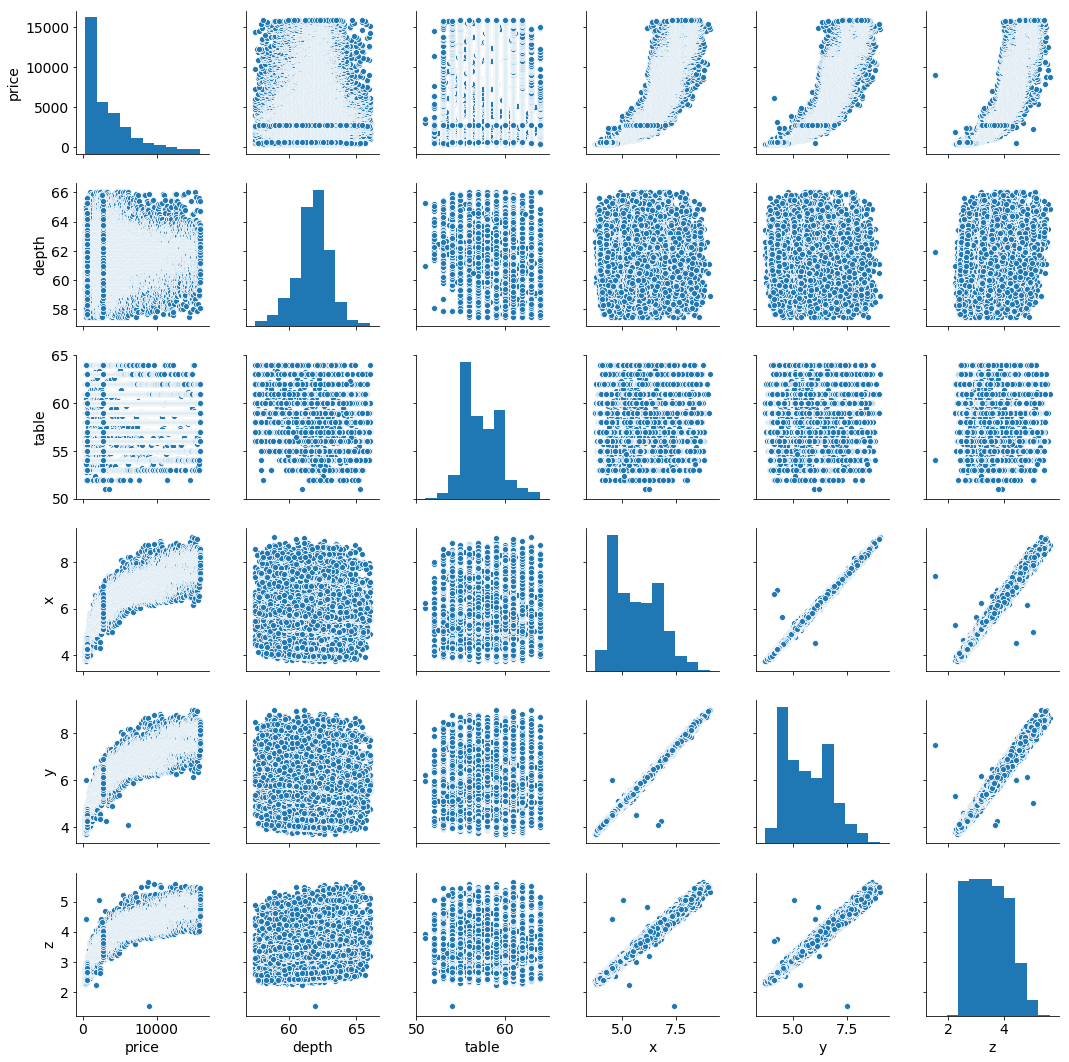

In [102]:
sns.pairplot(data)

There are some weird data points in here, particularly where z > 30 and y > 30. It looks like it's just two rows, so maybe we can drop it

In [9]:
data_coords = data[(data['y']>30) | (data['z']>30)]
data_coords.head()

price        cut color clarity  depth  table     x      y      z
35904   1970  Very Good     E     VS1   61.8   54.7  5.12   5.15  31.80
36493   2075      Ideal     E     VS1   61.8   55.0  5.15  31.80   5.12

Yep, only 2 rows. Since I am going to replace the values where x,y and z == 0 with their respective means, I am going to drop these two so they don't skew the mean to be artificially high.

In [11]:
data = data.loc[~((data['y'] > 20) | (data['z'] > 20))]

In [12]:
data.loc[(data['y']>20) | (data['z']>20)].count()

price      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

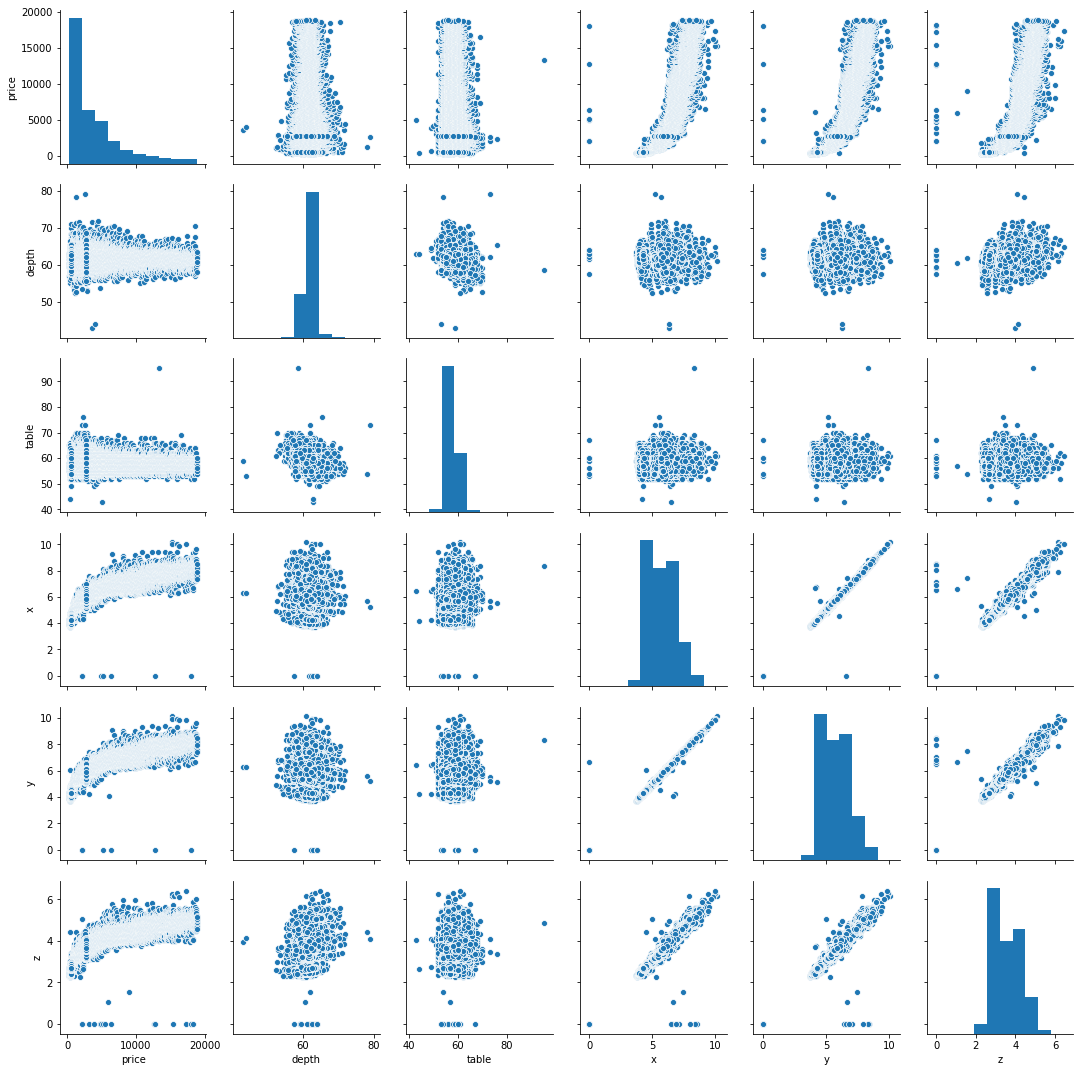

In [13]:
sns.pairplot(data)

Looking better. Now to deal with those pesky 0's in the x, y and z columns. These are obviously bad data points, since a diamond needs 3 dimensions in order to exist.

In [14]:
data.describe()

price         depth         table             x             y  \
count  39998.000000  39998.000000  39998.000000  39998.000000  39998.000000   
mean    3927.111356     61.753703     57.460971      5.729214      5.731107   
std     3982.303243      1.430041      2.234599      1.121145      1.112574   
min      326.000000     43.000000     43.000000      0.000000      0.000000   
25%      949.000000     61.000000     56.000000      4.710000      4.720000   
50%     2401.000000     61.800000     57.000000      5.700000      5.710000   
75%     5313.750000     62.500000     59.000000      6.540000      6.540000   
max    18823.000000     79.000000     95.000000     10.140000     10.100000   

                  z  
count  39998.000000  
mean       3.537385  
std        0.694795  
min        0.000000  
25%        2.910000  
50%        3.520000  
75%        4.030000  
max        6.430000

In [15]:
zero_coords = data[(data['x']==0) | (data['y']==0) | (data['z']==0)]
zero_coords

price        cut color clarity  depth  table     x     y    z
1640    3142    Premium     G     SI2   59.1   59.0  6.55  6.48  0.0
4054    3837    Premium     F     SI2   59.2   58.0  6.50  6.47  0.0
7560    4731       Good     G      I1   64.0   61.0  7.15  7.04  0.0
8318    4954      Ideal     F     SI2   61.6   56.0  0.00  6.62  0.0
8901    5139  Very Good     H     VS2   63.3   53.0  0.00  0.00  0.0
10113   5564      Ideal     G     VS2   59.2   56.0  6.88  6.83  0.0
11881   6381       Fair     G     VS1   57.5   67.0  0.00  0.00  0.0
18133  12631    Premium     H     SI2   59.4   61.0  8.49  8.45  0.0
18229  12800      Ideal     G     VS2   62.2   54.0  0.00  0.00  0.0
19411  15397    Premium     I     SI1   61.3   58.0  8.52  8.42  0.0
20149  17265    Premium     H     SI1   61.2   59.0  8.42  8.37  0.0
20370  18034    Premium     H     SI2   62.8   59.0  0.00  0.00  0.0
20423  18207    Premium     H     VS2   62.7   53.0  8.02  7.95  0.0
36761   2130       Good     F     SI2   64.1   60.0  0.00  0.00  0.0
36762   2130       Good     F     SI2   64.1   60.0  0.00  0.00  0.0

I am going to replace these with the means for each column.

In [16]:
data.loc[:,['x','y','z']] = data[['x','y','z']].replace(0,np.nan).fillna(data[['x','y','z']].mean())

# data.loc[data.x == 0, 'x'] = data['x'].mean()
# data.loc[data.y == 0, 'y'] = data['y'].mean()
# data.loc[data.z == 0, 'z'] = data['z'].mean()

In [17]:
data.loc[(data['x']==0) | (data['y']==0) | (data['z']==0)].count()

price      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

In [18]:
data.describe()

price         depth         table             x             y  \
count  39998.000000  39998.000000  39998.000000  39998.000000  39998.000000   
mean    3927.111356     61.753703     57.460971      5.730217      5.731966   
std     3982.303243      1.430041      2.234599      1.118580      1.110357   
min      326.000000     43.000000     43.000000      3.730000      3.710000   
25%      949.000000     61.000000     56.000000      4.710000      4.720000   
50%     2401.000000     61.800000     57.000000      5.700000      5.710000   
75%     5313.750000     62.500000     59.000000      6.540000      6.540000   
max    18823.000000     79.000000     95.000000     10.140000     10.100000   

                  z  
count  39998.000000  
mean       3.538712  
std        0.691408  
min        1.070000  
25%        2.910000  
50%        3.530000  
75%        4.030000  
max        6.430000

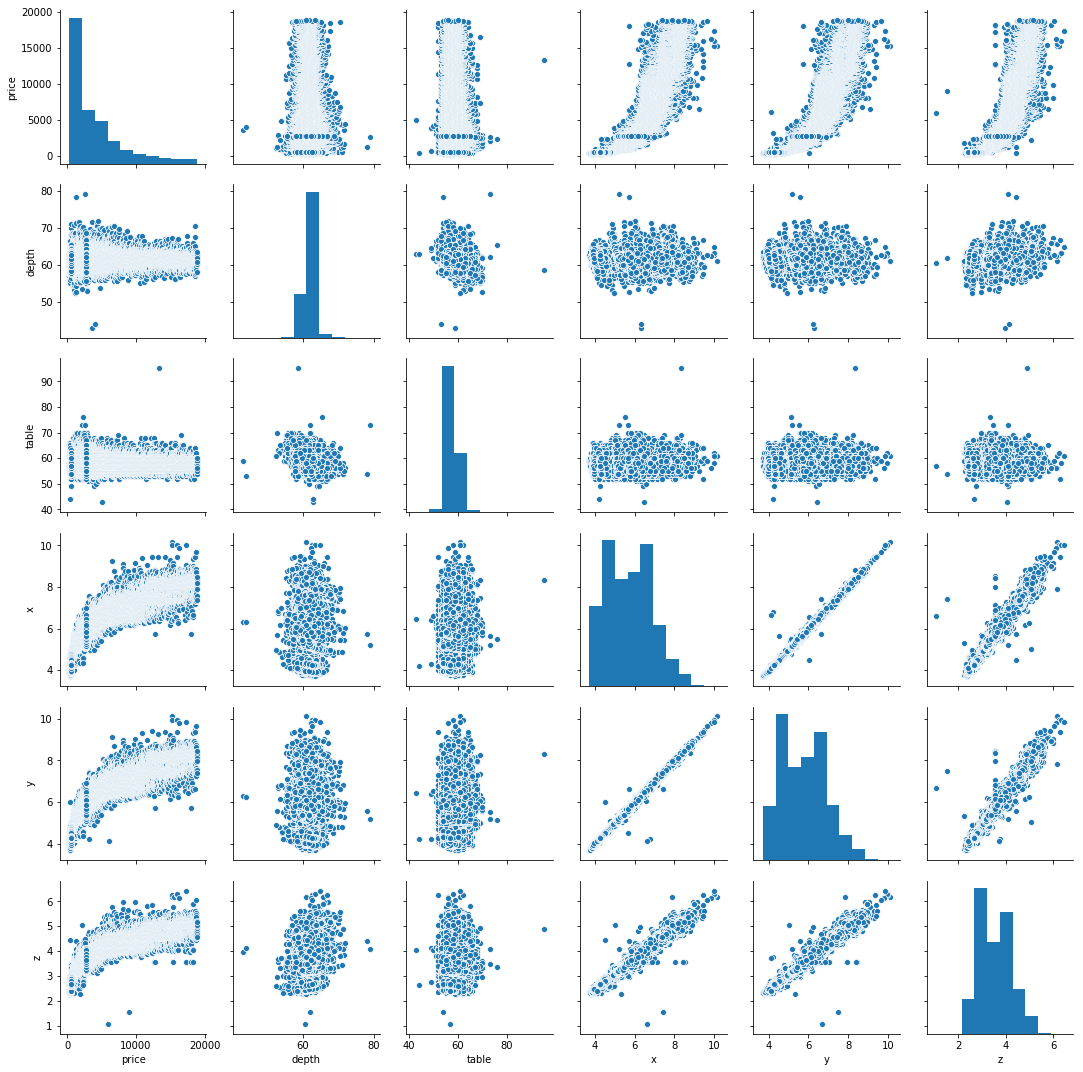

In [19]:
sns.pairplot(data)

Now we are getting somewhere. The only other data point that stands out to me as peculiar is the table > 80. I am going to drop that bad boy as well.

In [20]:
data = data.loc[~(data['table'] > 80)]

Let's productionize this so we don't have to manually look for outliers. The following code will only keep rows where all values are within 3 standard deviations from the mean.

In [21]:
outlier_mask = (np.abs(stats.zscore(data.select_dtypes(include=np.number)))<3).all(axis=1)
data = data[outlier_mask]
data.describe()

price         depth         table             x             y  \
count  38380.000000  38380.000000  38380.000000  38380.000000  38380.000000   
mean    3615.932282     61.756855     57.373893      5.666621      5.669801   
std     3473.276419      1.267412      2.096232      1.068475      1.060978   
min      326.000000     57.500000     51.000000      3.730000      3.710000   
25%      928.000000     61.100000     56.000000      4.690000      4.700000   
50%     2316.000000     61.800000     57.000000      5.660000      5.670000   
75%     5080.000000     62.500000     59.000000      6.490000      6.490000   
max    15864.000000     66.000000     64.000000      9.080000      9.010000   

                  z  
count  38380.000000  
mean       3.500160  
std        0.660172  
min        1.530000  
25%        2.890000  
50%        3.500000  
75%        4.020000  
max        5.580000

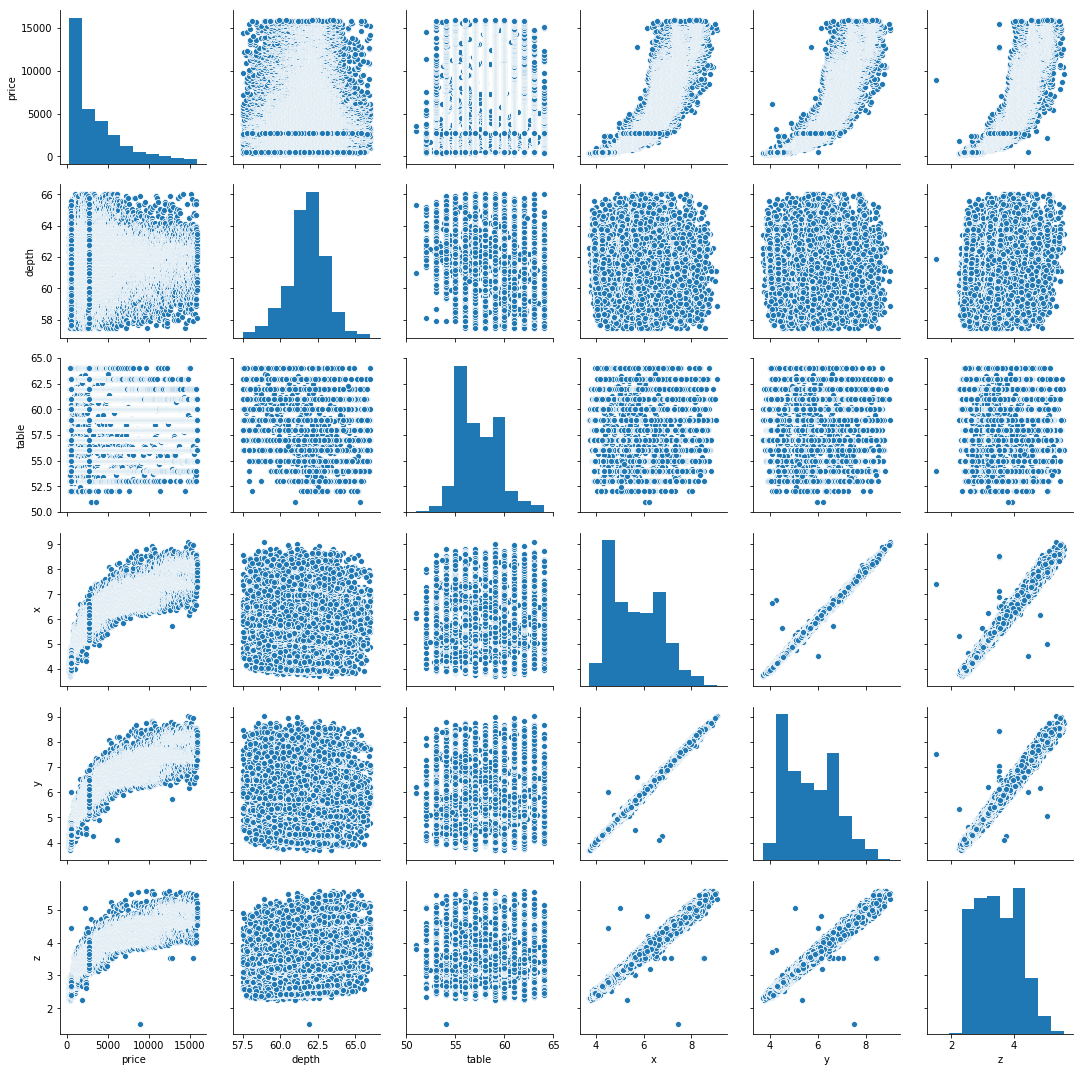

In [22]:
sns.pairplot(data)

In [23]:
data['clarity'] = data['clarity'].map({'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8})
data['cut'] = data['cut'].map({'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5})
data['color'] = data['color'].map({'D': 7, 'E': 6, 'F': 5, 'G': 4, 'H': 3, 'I': 2, 'J': 1})

In [27]:
data['log_volume']= np.log(data['x'] * data['y'] * data['z'])
data['log_price']= np.log(data['price'])

In [40]:
data['price'].mean()

3615.93228243877

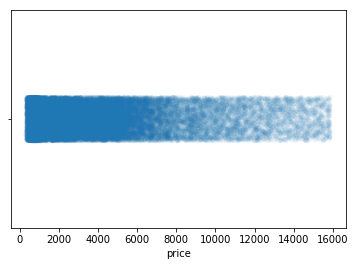

In [28]:
sns.stripplot(x = 'price', data=data, alpha = 0.05)

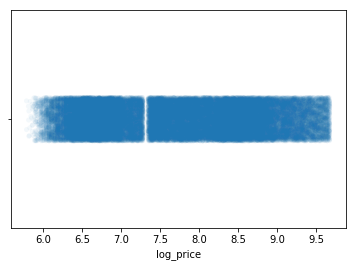

In [29]:
sns.stripplot(x = 'log_price', data=data, alpha = 0.05)

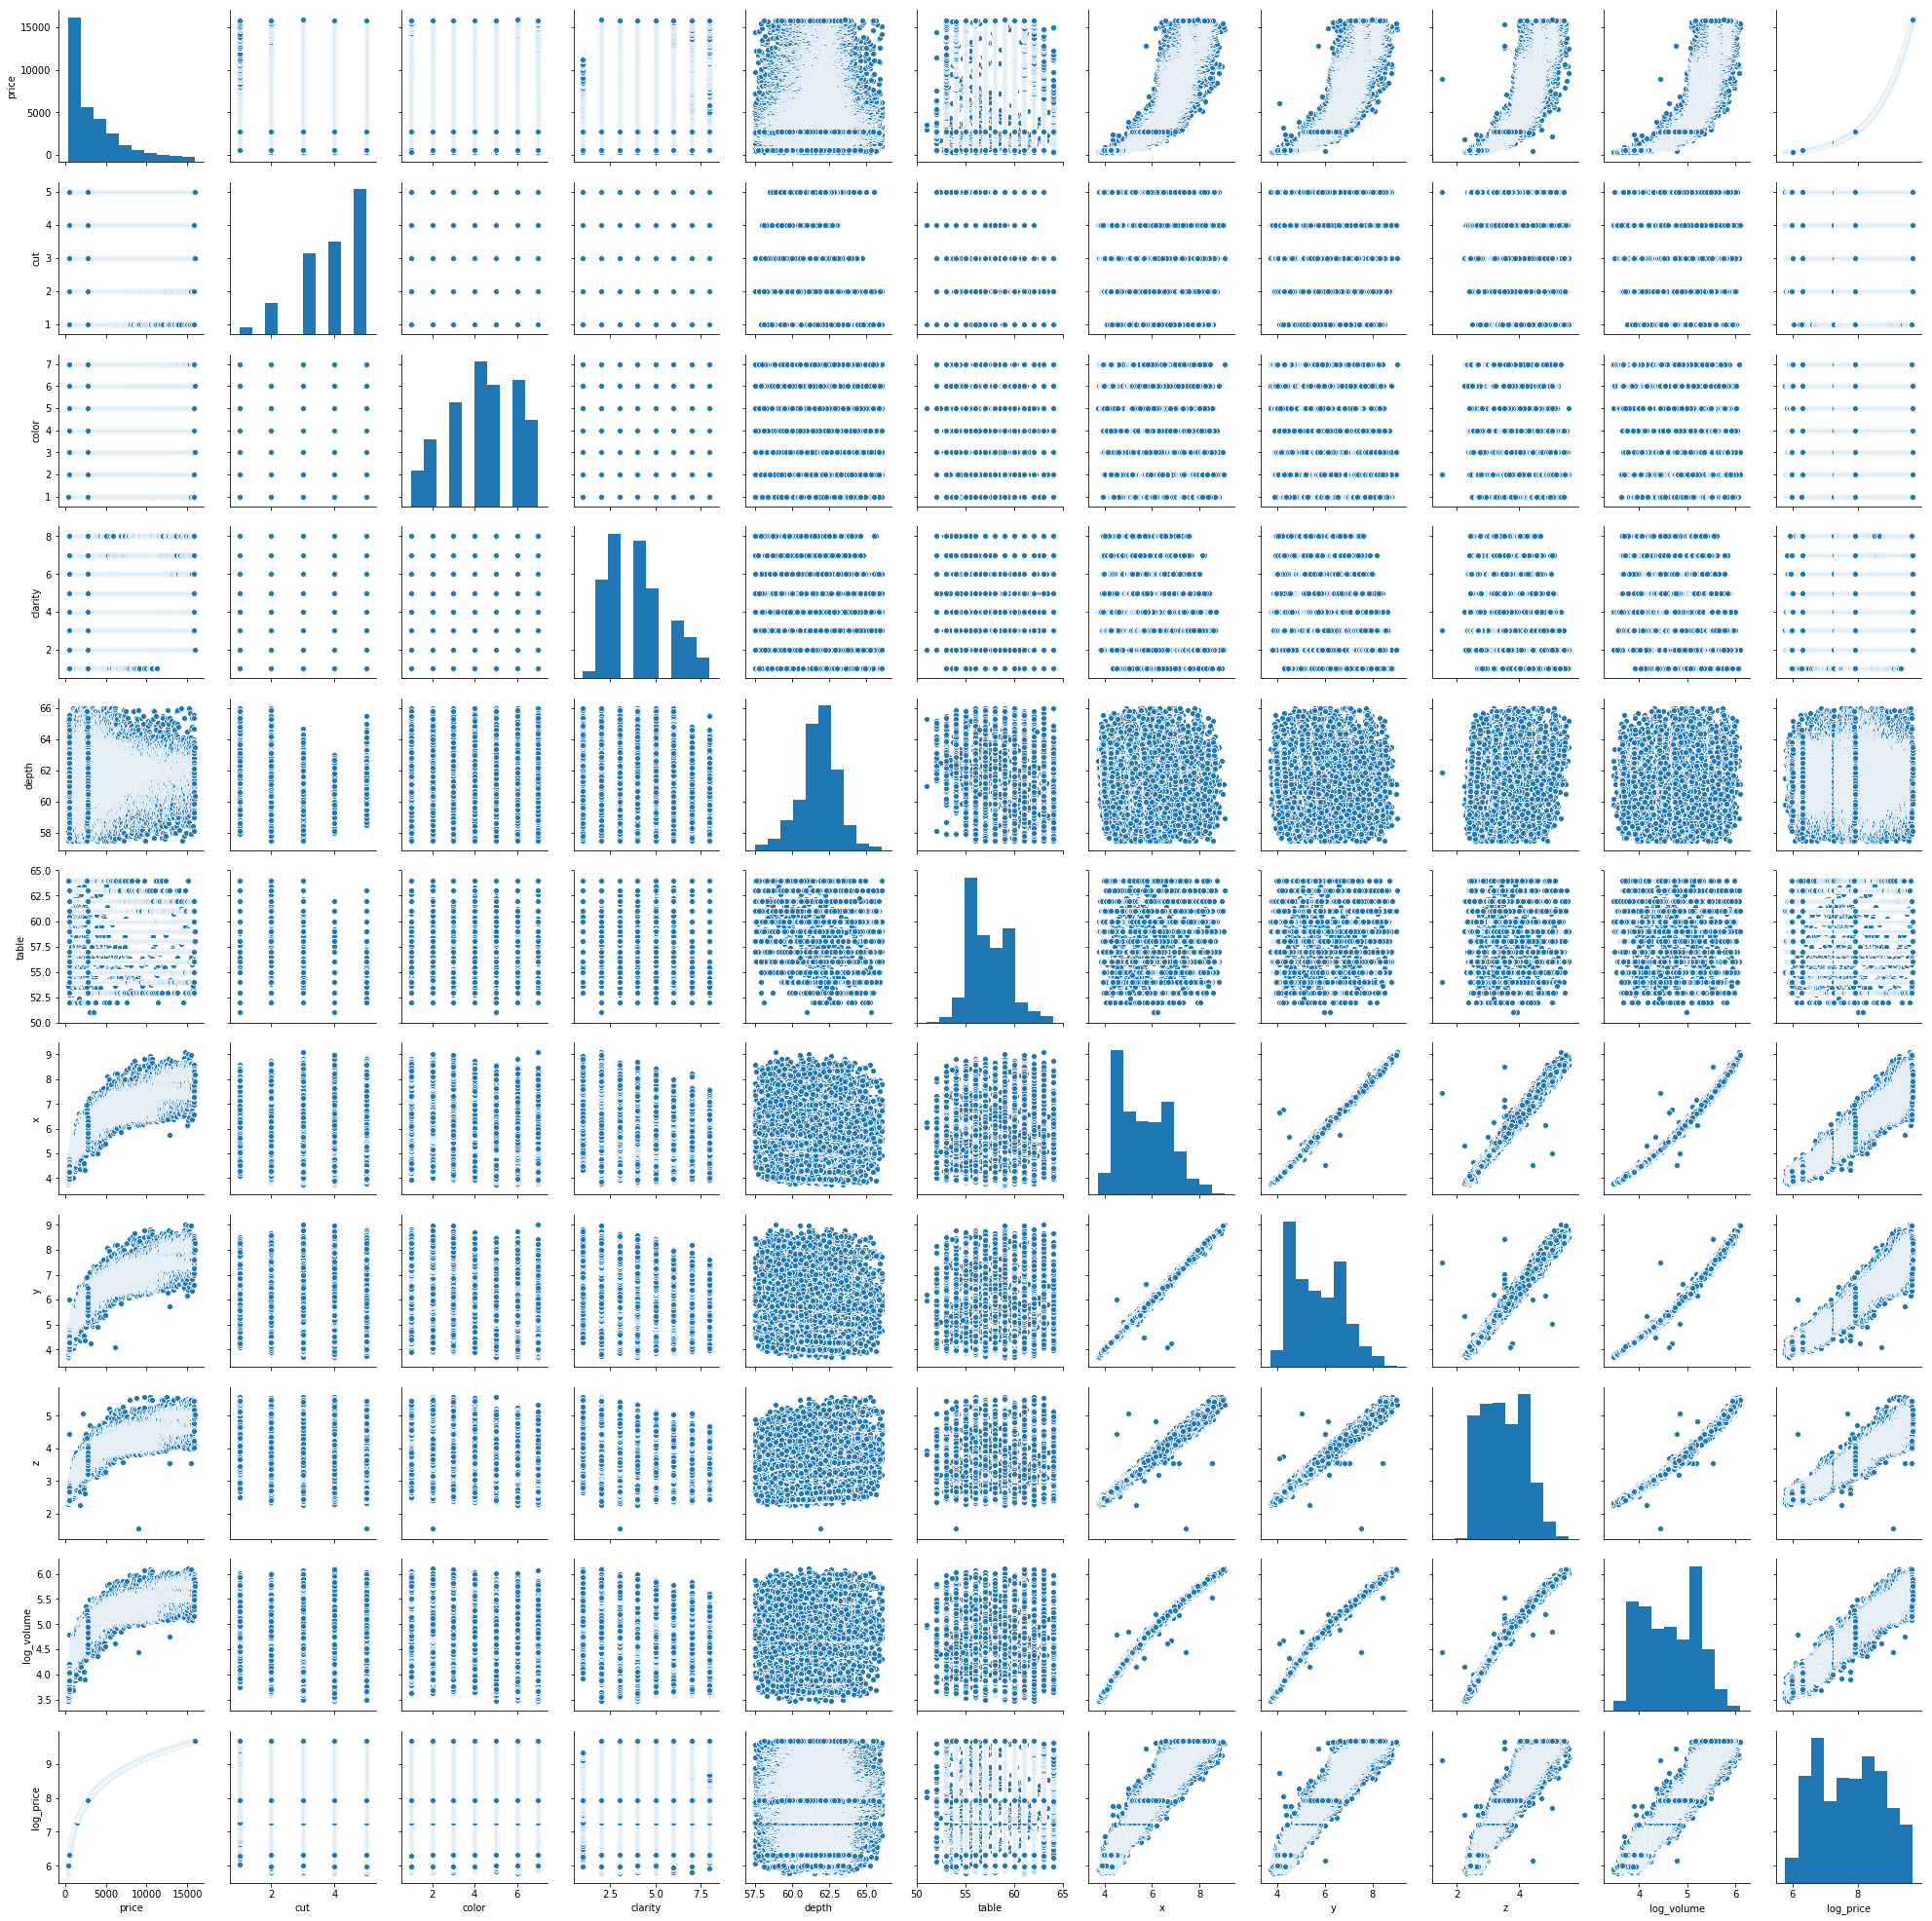

In [30]:
sns.pairplot(data)

In [31]:
def summary_model(X_train, y_train, label='scatter'):
    X = sm.add_constant(X_train)
    model = sm.OLS(y_train, X).fit()
    summary = model.summary()
    return summary

def predict_model(X_train, y_train, X_test, y_test, label='Prediction vs. True'):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    model = sm.OLS(y_train, X_train).fit()
    predictions = model.predict(X_test)

    plt.scatter(y_test, predictions, label=label)
    plt.legend()
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

def plot_model(X, y, label='Residual Plot'):
    X = sm.add_constant(X_train)
    model = sm.OLS(y, X).fit()
    student_resids = model.outlier_test()['student_resid']
    y_hats = model.predict(X)

    plt.scatter(y_hats, student_resids, alpha = .15, label=label)
    plt.legend()
    plt.show()

In [32]:
data_model = data[['log_price','color','cut','clarity','log_volume','table']]

X = data_model.copy()
y = X.pop('log_price')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 101)

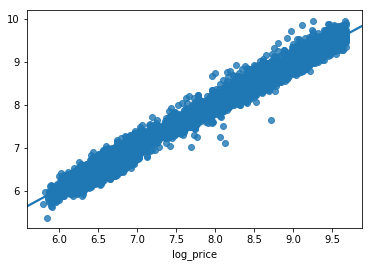

In [33]:
lm = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=-2)
lm.fit(X_train,y_train)
y_predicted = lm.predict(X_test)
sns.regplot(y_test, y_predicted)

In [34]:
coeffs = pd.DataFrame(lm.coef_)
coeffs.index = X_train.columns
coeffs.rename({0:'value'}, axis = 1, inplace = True)
coeffs = coeffs.sort_values(by = ['value'], ascending = False)
coeffs

value
log_volume  1.887011
clarity     0.119538
color       0.076678
cut         0.019685
table       0.004094

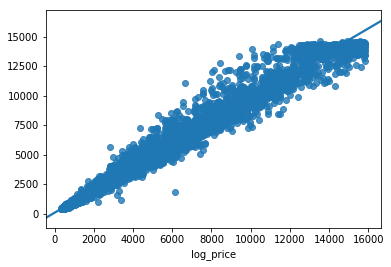

In [35]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, n_jobs=-2)
rf.fit(X_train,y_train)
y_predicted = rf.predict(X_test)
sns.regplot(np.exp(y_test), np.exp(y_predicted))

In [36]:
feat = pd.DataFrame(rf.feature_importances_)
feat.index = X_train.columns
feat.rename({0:'feature_importance'}, axis = 1, inplace = True)
feat = feat.sort_values(by = 'feature_importance', ascending = False)
feat

feature_importance
log_volume            0.951334
clarity               0.032720
color                 0.014500
cut                   0.001002
table                 0.000444

/home/carlywolfbrandt/anaconda3/envs/dsi/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


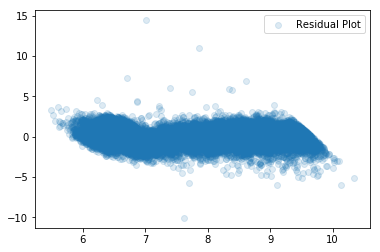

In [38]:
plot_model(X_train, y_train, label='Residual Plot for OLS')

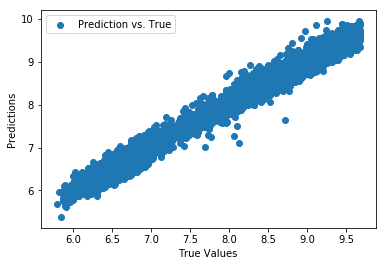

In [39]:
predict_model(X_train, y_train, X_test, y_test, label='OLS Prediction vs. True')